# Feature Engineering

* This notebook uses a preprocessed dataset available at the following link https://github.com/jroccal/hydropower_energy_forecasting/blob/main/notebooks/preprocessing.ipynb

* The objective of this notebook is to compute additional features derived from the provided energy consumption, and climate variables.

* Recall that the overall goal is to predict the energy consumption of each user_data entry associated with a specific `consumer_device`, for the month following the timeframe covered by the provided energy dataset.

In [22]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path_data = 'hydropower-zindi-challenge/'

In [ ]:
df_data = pd.read_parquet(path_data+'df_daily_energy_data.parquet')
df_climate = pd.read_parquet(path_data+'df_daily_climate_data.parquet')
df_data.shape, df_climate.shape

((136409, 25), (511, 27))

In [ ]:
df_data.head()

,source_original,date,v_red_mean,v_red_std,v_red_median,v_blue_mean,v_blue_std,v_blue_median,v_yellow_mean,v_yellow_std,...,power_factor_std,power_factor_median,kwh,month,year,day,is_three_phases,voltage,consumer_device,data_user
0,consumer_device_3_data_user_10,2023-06-03,1.343381,15.838232,0.0,NaN,NaN,NaN,NaN,NaN,...,0.062766,0.0,0.000921,6.0,2023.0,3.0,0.0,1.343381,consumer_device_3,10
1,consumer_device_3_data_user_6,2023-06-03,NaN,NaN,NaN,1.34482,15.855196,0.0,NaN,NaN,...,0.067855,0.0,0.000997,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,6
2,consumer_device_3_data_user_3,2023-06-03,1.343381,15.838232,0.0,NaN,NaN,NaN,NaN,NaN,...,0.064462,0.0,0.001183,6.0,2023.0,3.0,0.0,1.343381,consumer_device_3,3
3,consumer_device_3_data_user_11,2023-06-03,NaN,NaN,NaN,NaN,NaN,NaN,1.34482,15.855196,...,0.061070,0.0,0.001009,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,11
4,consumer_device_3_data_user_9,2023-06-03,NaN,NaN,NaN,NaN,NaN,NaN,1.34482,15.855196,...,0.062766,0.0,0.000922,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,9


## Features Over Energy Data

* During the EDA step, we observed that the energy consumption patterns of users within each `consumer_device` group are quite similar.
* Based on this, we can compute statistical summaries over the historical energy data for each `consumer_device`, aggregating across all associated `user_data` time series.
* These aggregated statistics will serve as a static predictor, representing the typical monthly energy consumption behavior for each `consumer_device`.

In [ ]:
def compute_statistics(x):
    return pd.concat([x.groupby(['day'])['kwh'].describe()[['std', '25%',	'50%', '75%']],
               x.groupby(['day'])['voltage'].describe()[['std', '25%',	'50%', '75%']],
               x.groupby(['day'])['power_factor_mean'].describe()[['std', '25%',	'50%', '75%']],
               x.groupby(['day'])['current_mean'].describe()[['std', '25%',	'50%', '75%']]
              ], axis=1
             )
df_stat_energy_features = df_data.groupby('consumer_device').apply(lambda x: compute_statistics(x)).reset_index()
df_stat_energy_features.columns = ['consumer_device',	'day',
                                   'statskhw_std',	'statskhw_q1',	'statskhw_q2',	'statskhw_q3',
                                   'statsvol_std',	'statsvol_q1',	'statsvol_q2',	'statsvol_q3',
                                   'statspof_std',	'statspof_q1',	'statspof_q2',	'statspof_q3',
                                   'statscur_std',	'statscur_q1',	'statscur_q2',	'statscur_q3']
print(df_stat_energy_features.shape)

(1209, 18)


In [9]:
df_stat_energy_features.head()

,consumer_device,day,statskhw_std,statskhw_q1,statskhw_q2,statskhw_q3,statsvol_std,statsvol_q1,statsvol_q2,statsvol_q3,statspof_std,statspof_q1,statspof_q2,statspof_q3,statscur_std,statscur_q1,statscur_q2,statscur_q3
0,consumer_device_1,1.0,0.627312,0.053814,0.056463,0.067704,0.087201,49.291875,49.291875,49.457326,0.073879,0.267951,0.316701,0.321771,0.243438,0.026528,0.027917,0.081806
1,consumer_device_1,2.0,0.366305,0.024950,0.026582,0.028770,0.042841,23.455937,23.455937,23.537222,0.051724,0.123889,0.181840,0.194965,0.152204,0.015382,0.016111,0.050035
2,consumer_device_1,3.0,0.821864,0.069353,0.076538,0.095523,0.118915,65.895972,65.895972,66.121597,0.116502,0.236806,0.360972,0.442813,0.325194,0.033854,0.036840,0.112500
3,consumer_device_1,4.0,0.405120,0.021081,0.023148,0.026148,0.037442,20.256806,20.256806,20.327847,0.042454,0.114931,0.140799,0.166875,0.179613,0.012604,0.013715,0.042222
4,consumer_device_1,5.0,1.196409,0.031973,0.035472,0.043143,0.057389,32.187951,32.187951,32.296840,0.061196,0.113472,0.195000,0.202847,0.403772,0.015035,0.016528,0.051493


array([<Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>], dtype=object)

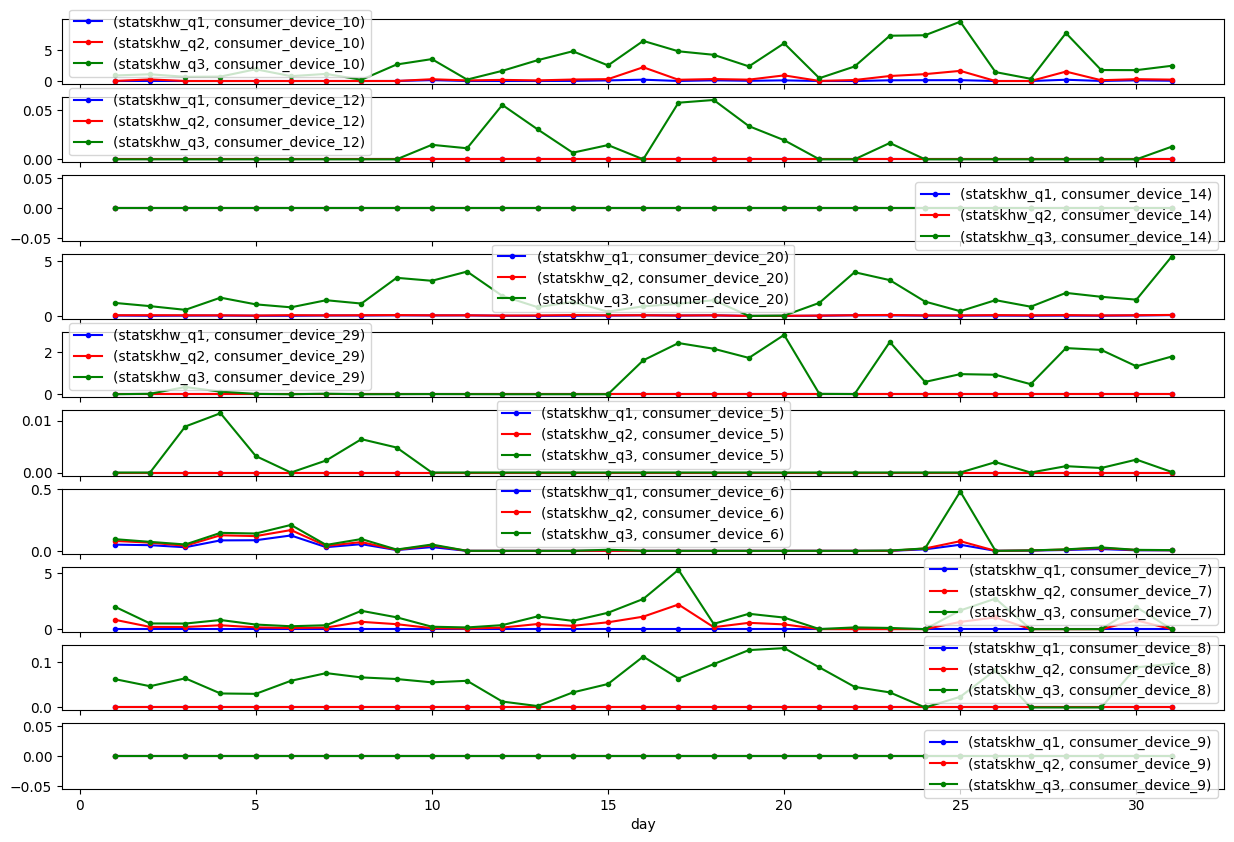

In [18]:
list_sample_devices = df_stat_energy_features['consumer_device'].drop_duplicates().sample(10)


ax = df_stat_energy_features[df_stat_energy_features['consumer_device'].isin(list_sample_devices)][['day', 'consumer_device', 'statskhw_q1']].set_index(['day', 'consumer_device']).unstack()\
.plot(style='.-', subplots=True, sharex=True, figsize=(15,10), color='blue')
df_stat_energy_features[df_stat_energy_features['consumer_device'].isin(list_sample_devices)][['day', 'consumer_device', 'statskhw_q2']].set_index(['day', 'consumer_device']).unstack()\
.plot(style='.-', subplots=True, sharex=True, ax=ax, color='red')
df_stat_energy_features[df_stat_energy_features['consumer_device'].isin(list_sample_devices)][['day', 'consumer_device', 'statskhw_q3']].set_index(['day', 'consumer_device']).unstack()\
.plot(style='.-', subplots=True, sharex=True, ax=ax, color='green')

## Time features

In [19]:
## compute time features
df_time_features = df_climate[['date_']].copy()
df_time_features.rename(columns={'date_':'date'}, inplace=True) #, 'date_hour_group_':'date_hour_group', 'hour_group_':'hour_group'}, inplace=True)
df_time_features['day'] = df_time_features['date'].dt.day
df_time_features['dayofweek'] = df_time_features['date'].dt.dayofweek
df_time_features['is_weekend'] = df_time_features['dayofweek'].isin([5,6]).astype(int)
df_time_features.shape

(511, 4)

## Climate features

In [21]:
def year_month_cat_plot(df, column, filter_months=0, title=''):
  filter_tmp = (df['month']>filter_months)
  color_order = list(np.arange(31)+1)
  g = sns.catplot(
      data=df[filter_tmp], kind="box",
      x="month", y=column,
      col='year',
      errorbar="sd", palette="dark",
      height=5, aspect=1.3,
      hue_order=color_order
  )
  g.despine(left=True)
  g.set_axis_labels("", "box")
  plt.subplots_adjust(top=0.85)
  plt.suptitle(title, fontsize=12)

In [20]:
df_climate['wind_speed'] = np.sqrt(df_climate['u_wind_mean']**2 + df_climate['v_wind_mean']**2)
df_climate['wind_dir_deg'] = (np.arctan2(df_climate['u_wind_mean'], df_climate['v_wind_mean']) * 180 / np.pi) % 360

dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
df_climate['wind_dir_sector'] = pd.cut(
    df_climate['wind_dir_deg'],
    bins=[0, 45, 90, 135, 180, 225, 270, 315, 360],
    labels=dirs,
    include_lowest=True
)
df_climate['is_windy'] = (df_climate['wind_speed'] > 5).astype(int)

df_climate['dew_temp_diff'] = df_climate['temp_mean'] - df_climate['dew_temp_mean']
df_climate['precip_prev_day'] = df_climate['total_precip_mean'].shift(1)
df_climate['temp_rolling_3'] = df_climate['temp_mean'].rolling(3).mean() #15 = 3 days
df_climate['wind_rolling_3'] = df_climate['wind_speed'].rolling(3).mean()
df_climate['precip_cumulative_3'] = df_climate['total_precip_mean'].rolling(3).sum()
df_climate['temp_diff_day'] = df_climate['temp_mean'].diff()
df_climate['is_rainy_day'] = (df_climate['total_precip_mean'] > 0).astype(int)

df_climate['snowfall_rolling_3'] = df_climate['snowfall_mean'].rolling(3).mean()
df_climate['snow_cover_rolling_1'] = df_climate['snow_cover_mean'].rolling(1).mean() #1day
df_climate["precip_pchange_2"] = df_climate['total_precip_mean'].pct_change(2)
df_climate["temp_pchange_2"] = df_climate['temp_mean'].pct_change(2)
df_climate["wind_pchange_2"] = df_climate['wind_speed'].pct_change(2)
df_climate["wind_volat_2"] = np.log(df_climate['wind_speed']).diff().rolling(window=2).std()
df_climate.shape

(511, 44)

In [28]:
# ## save preprocessed data
df_stat_energy_features.to_parquet('df_daily_stat_energy_features.parquet')
df_time_features.to_parquet('df_daily_time_features.parquet')
df_climate.to_parquet('df_daily_climate_features.parquet')